# Applying a pretrained pipeline

In this tutorial, you will learn how to apply `pyannote.audio` pipelines on an audio file.

A pipeline takes an audio file as input and returns a labeled temporal segmentation of the audio file. 

More precisely, it usually applies a pretrained model (= neural network) on the audio file, post-processes the output of the model, and returns its output as a [`pyannote.core.Annotation`](http://pyannote.github.io/pyannote-core/structure.html#annotation) instance. It should become clearer as you keep reading...

## Loading pipeline from 🤗 hub

A bunch of pretrained pipelines are available on [🤗 Huggingface model hub](https://hf.co/models?other=pyannote-audio-pipeline) and can be listed by looking for the [`pyannote-audio-pipeline`](https://hf.co/models?other=pyannote-audio-pipeline) tag.

In [1]:
from huggingface_hub import HfApi
available_pipelines = [p.modelId for p in HfApi().list_models(filter="pyannote-audio-pipeline")]
list(filter(lambda p: p.startswith("pyannote/"), available_pipelines))

['pyannote/overlapped-speech-detection',
 'pyannote/speaker-diarization',
 'pyannote/speaker-segmentation',
 'pyannote/voice-activity-detection',
 'pyannote/speaker-diarization-3.0']

Official [pyannote.audio](https://github.com/pyannote/pyannote-audio) pipelines (i.e. those under the [`pyannote` organization](https://hf.co/pyannote) umbrella) are open-source, but gated. It means that you have to first accept users conditions on their respective Huggingface page to access the pretrained weights and hyper-parameters. Despite this initial process, those pipelines can perfectly be downloaded for later offline use: keep reading this tutorial until the end to learn how to do that.

For instance, to load the speaker diarization pipeline used in this tutorial, you have to visit [hf.co/pyannote/speaker-diarization](https://hf.co/pyannote/speaker-diarization), accept the terms, visit [hf.co/pyannote/segmentation](https://hf.co/pyannote/segmentation) (used internally by the speaker diarization pipeline), accept the terms, and log in using `notebook_login` below:

In [3]:
from huggingface_hub import notebook_login
notebook_login()

Once authenticated, you can load the pipeline (and the internal models)...

In [4]:
from pyannote.audio import Pipeline
pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization", use_auth_token=True)

/Users/jingming/miniforge3/envs/voice-biomarker-py311/lib/python3.11/site-packages/pyannote/audio/core/io.py:43: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")
/Users/jingming/miniforge3/envs/voice-biomarker-py311/lib/python3.11/site-packages/torch_audiomentations/utils/io.py:27: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")
torchvision is not available - cannot save figures
Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.1.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../.cache/torch/pyannote/models--pyannote--segmentation/snapshots/c4c8ceafcbb3a7a280c2d357aee9fbc9b0be7f9b/pytorch_model.b

Model was trained with pyannote.audio 0.0.1, yours is 3.0.0. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.1.0. Bad things might happen unless you revert torch to 1.x.


## Processing a file from disk

... and apply it to an audio file.  

The pipeline will automatically use GPUs when available. 
On CPU it might take a long while (up to 10x RT).

In [5]:
ROOT_DIR = "/Users/jingming/DataSets/淄博妇幼/voice-sample"
AUDIO_FILE = f"{ROOT_DIR}/574.wav"
dia = pipeline(AUDIO_FILE)

In [19]:
from pydub import AudioSegment
import os

def isexist(name, path=None):
    '''
    :param name: 需要检测的文件或文件夹名
    :param path: 需要检测的文件或文件夹所在的路径，当path=None时默认使用当前路径检测
    :return: True/False 当检测的文件或文件夹所在的路径下有目标文件或文件夹时返回Ture,
            当检测的文件或文件夹所在的路径下没有有目标文件或文件夹时返回False
    '''
    if path is None:
        path = os.getcwd()
    if os.path.exists(path + '/' + name):
        print("Under the path: " + path + '\n' + name + " is exist")
        return True
    else:
        if (os.path.exists(path)):
            print("Under the path: " + path + '\n' + name + " is not exist")
        else:
            print("This path could not be found: " + path + '\n')
        return False

for turn, _, speaker in dia.itertracks(yield_label=True):
    print(f"start={turn.start:.1f}s stop={turn.end:.1f}s speaker_{speaker}")
    newAudio = AudioSegment.from_wav(AUDIO_FILE)
    start = turn.start
    end = turn.end
    newAudio = newAudio[int(start * 1000):int(end * 1000)]
    if not isexist(name=speaker + '.wav', path='.'):
        newAudio.export(speaker + '.wav', format="wav")
    else:
        newAudio.export('temp.wav', format="wav")
        combined_sounds = AudioSegment.from_wav(speaker + ".wav")
        temp = AudioSegment.from_wav("temp.wav")
        combined_sounds = combined_sounds + temp
        # os.remove(speaker + '.wav')
        combined_sounds.export(speaker + '.wav', format="wav")
        os.remove('temp.wav')

start=0.0s stop=5.0s speaker_SPEAKER_02
Under the path: .
SPEAKER_02.wav is not exist
start=2.0s stop=4.2s speaker_SPEAKER_00
Under the path: .
SPEAKER_00.wav is not exist
start=8.7s stop=13.8s speaker_SPEAKER_02
Under the path: .
SPEAKER_02.wav is exist
start=14.4s stop=14.5s speaker_SPEAKER_02
Under the path: .
SPEAKER_02.wav is exist
start=14.5s stop=14.6s speaker_SPEAKER_00
Under the path: .
SPEAKER_00.wav is exist
start=17.6s stop=17.7s speaker_SPEAKER_00
Under the path: .
SPEAKER_00.wav is exist
start=17.7s stop=22.7s speaker_SPEAKER_02
Under the path: .
SPEAKER_02.wav is exist
start=18.7s stop=19.5s speaker_SPEAKER_00
Under the path: .
SPEAKER_00.wav is exist
start=22.7s stop=24.0s speaker_SPEAKER_00
Under the path: .
SPEAKER_00.wav is exist
start=24.7s stop=25.1s speaker_SPEAKER_02
Under the path: .
SPEAKER_02.wav is exist
start=26.9s stop=41.9s speaker_SPEAKER_02
Under the path: .
SPEAKER_02.wav is exist
start=42.9s stop=47.3s speaker_SPEAKER_00
Under the path: .
SPEAKER_00.wa

## Visualizing the output

Most pipelines return a [`pyannote.core.Annotation`](http://pyannote.github.io/pyannote-core/structure.html#annotation) instance...

In [6]:
from pyannote.core import Annotation
assert isinstance(dia, Annotation)

... whose [API](https://pyannote.github.io/pyannote-core/structure.html#annotation) you can use to print the result:

In [7]:
for speech_turn, track, speaker in dia.itertracks(yield_label=True):
    print(f"{speech_turn.start:4.1f} {speech_turn.end:4.1f} {speaker}")

 0.0  5.0 SPEAKER_02
 2.0  4.2 SPEAKER_00
 8.7 13.8 SPEAKER_02
14.4 14.5 SPEAKER_02
14.5 14.6 SPEAKER_00
17.6 17.7 SPEAKER_00
17.7 22.7 SPEAKER_02
18.7 19.5 SPEAKER_00
22.7 24.0 SPEAKER_00
24.7 25.1 SPEAKER_02
26.9 41.9 SPEAKER_02
42.9 47.3 SPEAKER_00
49.5 51.0 SPEAKER_00
51.6 56.0 SPEAKER_00
56.0 59.9 SPEAKER_01
61.5 66.3 SPEAKER_02
66.3 69.7 SPEAKER_01
70.6 76.1 SPEAKER_02
73.8 74.0 SPEAKER_01
74.7 75.0 SPEAKER_01
77.5 79.8 SPEAKER_02
80.9 89.8 SPEAKER_01
90.5 95.0 SPEAKER_02
94.1 94.3 SPEAKER_01
96.1 99.8 SPEAKER_02
109.0 112.6 SPEAKER_02
114.0 130.3 SPEAKER_01
132.2 136.4 SPEAKER_02
136.7 141.5 SPEAKER_01
142.0 143.3 SPEAKER_02
144.5 145.2 SPEAKER_02
146.0 147.4 SPEAKER_02
147.5 148.8 SPEAKER_01
151.1 153.0 SPEAKER_01
156.5 166.2 SPEAKER_02
165.3 167.9 SPEAKER_01
168.8 170.8 SPEAKER_00
169.0 169.0 SPEAKER_01
172.2 172.4 SPEAKER_00
173.8 181.4 SPEAKER_00
180.5 180.6 SPEAKER_02
183.9 187.5 SPEAKER_02
186.5 188.5 SPEAKER_00
188.5 208.6 SPEAKER_02
199.0 201.5 SPEAKER_00
208.6 218.0 SPE

If you happen to be running this example in a _Jupyter notebook_, `dia` can be [visualized directly](http://pyannote.github.io/pyannote-core/visualization.html):

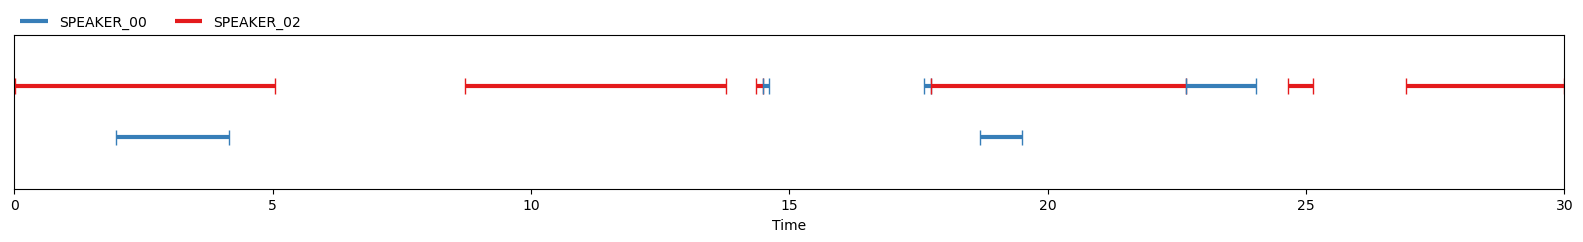

In [8]:
# we visualize [0, 30] time range
from pyannote.core import notebook, Segment
notebook.crop = Segment(0, 30)
dia

When available, the reference annotation can be visualized too, for comparison:

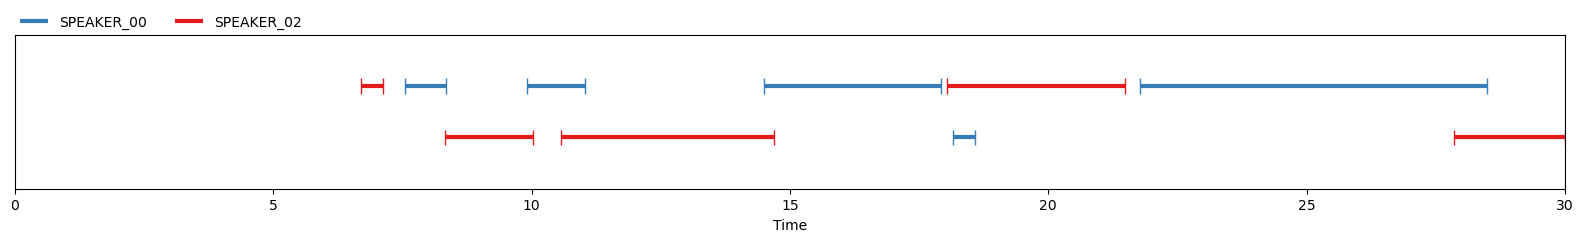

In [10]:
from pyannote.database.util import load_rttm
REFERENCE = f"{ROOT_DIR}/tutorials/assets/sample.rttm"
reference = load_rttm(REFERENCE)["sample"]

# map hypothesized and reference speakers for visualization purposes
pipeline.optimal_mapping(dia, reference)

## Processing a file from memory

In case the audio file is not stored on disk, pipelines can also process audio provided as a `{"waveform": ..., "sample_rate": ...}` dictionary. 

In [11]:
import torchaudio
waveform, sample_rate = torchaudio.load(AUDIO_FILE)

print(f"{type(waveform)=}")
print(f"{waveform.shape=}")
print(f"{waveform.dtype=}")

audio_in_memory = {"waveform": waveform, "sample_rate": sample_rate}

type(waveform)=<class 'torch.Tensor'>
waveform.shape=torch.Size([1, 480000])
waveform.dtype=torch.float32


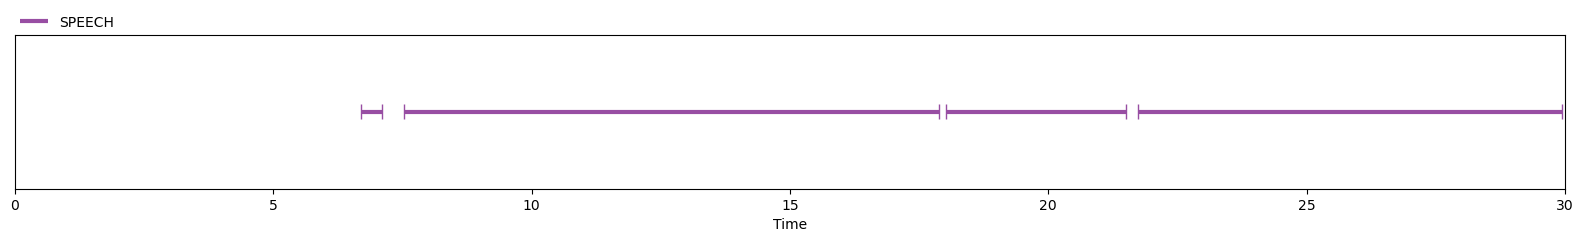

In [12]:
vad = Pipeline.from_pretrained("pyannote/voice-activity-detection", use_auth_token=True)
vad(audio_in_memory)

## Offline use

Gating models and pipelines allows [me](https://herve.niderb.fr) to know a bit more about `pyannote.audio` user base and eventually help me write grant proposals to make `pyannote.audio` even better. Please fill this form as precisely as possible. 

For instance, before gating `pyannote/speaker-diarization`, I had no idea that so many people were relying on it in production. Hint: sponsors are more than welcome! maintaining open source libraries is time consuming.

That being said: this whole authentication process does not prevent you from using official `pyannote.audio` models and pipelines offline (i.e. without going through the authentication process in every `docker run ...` or whatever you are using in production).

* Step 1: download `config.yaml` of [`pyannote/voice-activity-detection`](https://hf.co/pyannote/voice-activity-detection) pipeline

![](assets/download-pipeline.png)

* Step 2: download the `pytorch_model.bin` model

![](assets/download-model.png)

* Step 3: edit `config.yaml` to point to the local model

```diff
pipeline:
  name: pyannote.audio.pipelines.VoiceActivityDetection
  params:
-    segmentation: pyannote/segmentation@Interspeech2021
+    segmentation: pytorch_model.bin

params:
  min_duration_off: 0.09791355693027545
  min_duration_on: 0.05537587440407595
  offset: 0.4806866463041527
  onset: 0.8104268538848918
```

* Step 4: load the pipeline

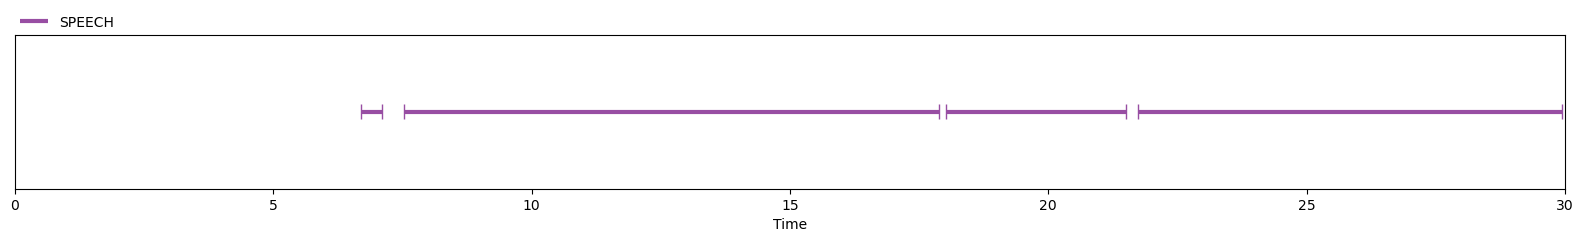

In [21]:
# look ma: no hands!
offline_vad = Pipeline.from_pretrained("config.yaml")
offline_vad(audio_in_memory)

In [22]:
# just checking output is the same
assert (vad(audio_in_memory) == offline_vad(audio_in_memory))